# 1D parameter estimation using MCMC: kernel multplication

This example will cover:

 - Use MCMC to infer kernel paramaters
 - Finding sample with highest log-prob from the mcmc chain
 - Visualising results of sampling
 - Making predictions


In [1]:
from gpvecchia import cov
from gpvecchia.vecchia import GPtideVecchia
import numpy as np
import matplotlib.pyplot as plt

import corner
import arviz as az

from gptide import stats as gpstats

## Generate some data

Remember we need numba cov functions

In [2]:
from numba import njit

@njit(cache=True)
def matern32_1d(X, Xp, covparams):
    eta, l = covparams
    d = 0.0
    for i in range(len(X)):
        d += (X[i] - Xp[i])**2
    return eta**2. * cov.matern32(d**0.5, l)

In [3]:
####
# These are our kernel input parameters
np.random.seed(1)
noise = 0
η_m = 4
ℓ_m = 150

covfunc = matern32_1d

###
# Domain size parameters
dx = 25.
N = 10000
covparams = (η_m, ℓ_m)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]

# A re-ordering function should always be specified - the default is no re-ordering
order_func = np.random.permutation
order_params = len(xd)

GP = GPtideVecchia(xd, xd, noise, covfunc, covparams,
                   order_func=order_func, order_params=order_params)

# Use the .prior() method to obtain some samples
yd = GP.sample_prior(samples=1)


(0.0, 5000.0)

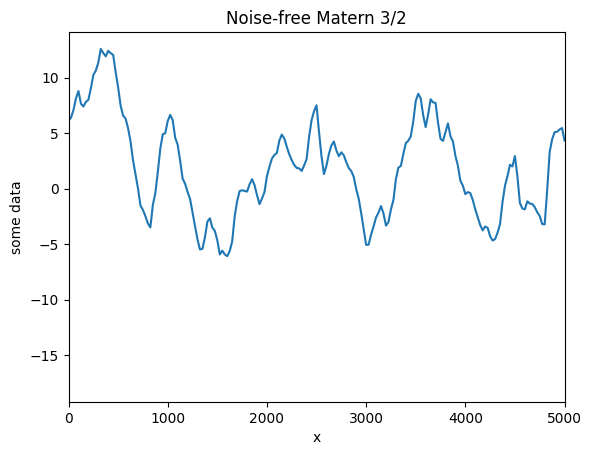

In [4]:
plt.figure()
plt.plot(xd, yd)
plt.ylabel('some data')
plt.xlabel('x')
plt.title('Noise-free Matern 3/2')
plt.xlim(0,5000)

In [19]:
@njit(cache=True)
def cosine_1d(X, Xp, covparams):
    eta, l = covparams
    d = 0.0
    for i in range(len(X)):
        d += (X[i] - Xp[i])**2
    return eta**2. * cov.cosine(d**0.5, l)

In [20]:
np.random.seed(1)
noise = 0

ℓ_p = 600
η_p = 4

covfunc = cosine_1d

covparams = (η_p, ℓ_p)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]

GP = GPtideVecchia(xd, xd, noise, covfunc, covparams,
                   order_func=order_func, order_params=order_params)

# Use the .prior() method to obtain some samples
yd = GP.sample_prior(samples=1)


(0.0, 5000.0)

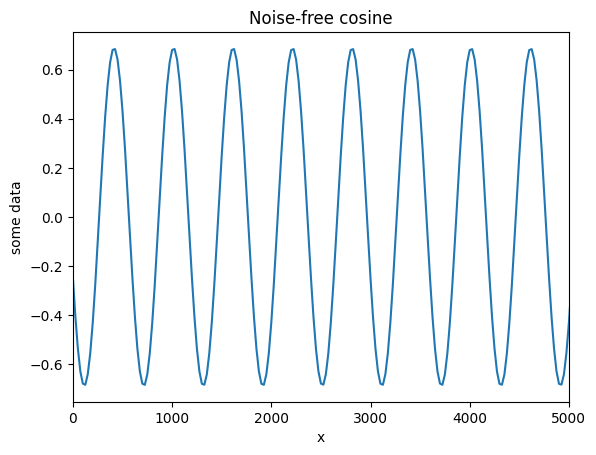

In [21]:
plt.figure()
plt.plot(xd, yd)
plt.ylabel('some data')
plt.xlabel('x')
plt.title('Noise-free cosine')
plt.xlim(0,5000)

### Create the mixed kernel


In [22]:
@njit(cache=True)
def matern32_cosine_1d(X, Xp, covparams):
    eta_m, l_m, eta_p, l_p = covparams
    ds = 0
    for i in range(len(X)):
        ds += (X[i] - Xp[i])**2
    d = ds**0.5
    fac2 = (3 * ds)**0.5
    mat32 = eta_m**2. * (1 + fac2/l_m)*np.exp(-fac2/l_m)
    cos = eta_p**2. * np.cos(2*np.pi*d/l_p)
    return mat32 + cos


In [23]:
np.random.seed(1)
noise = 0.5

covfunc = matern32_cosine_1d

covparams = (η_m, ℓ_m, η_p, ℓ_p)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]

GP = GPtideVecchia(xd, xd, noise, covfunc, covparams,
                   order_func=order_func, order_params=order_params)

# Use the .sample_prior() method to obtain some samples
yd = GP.sample_prior(samples=1)


In [24]:
import time
start = time.time()
ll = GP.log_marg_likelihood(yd)
end = time.time()
print('Log marginal likelihood: ', ll)
print('Time taken: ', end-start)

Log marginal likelihood:  [-4244.70582167]
Time taken:  11.245912313461304


(0.0, 5000.0)

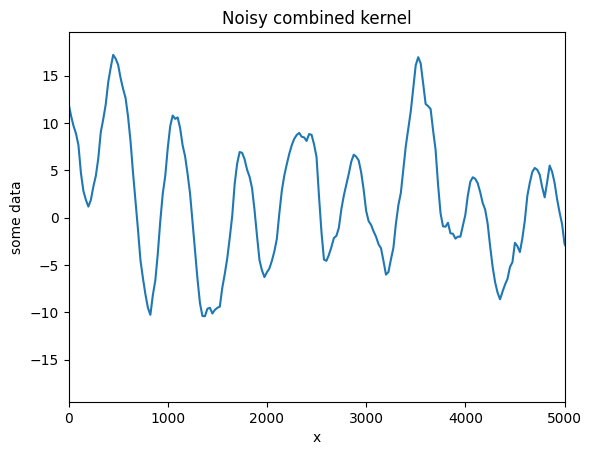

In [25]:
plt.figure()
plt.plot(xd, yd)
plt.ylabel('some data')
plt.xlabel('x')
plt.title('Noisy combined kernel')
plt.xlim(0,5000)

## Inference

We now use the `gptide.mcmc` function do the parameter estimation. This uses the `emcee.EnsembleSampler` class.


In [26]:
from gptide import mcmc
n = len(xd)

In [ ]:
# Initial guess of the noise and covariance parameters (these can matter)

noise_prior      = gpstats.truncnorm(0.4, 0.25, 1e-15, 1e2)         # noise - true value 0.5
covparams_priors = [gpstats.truncnorm(1, 1, 1e-15, 1e2),              # η_m - true value 4
                    gpstats.truncnorm(125, 50, 1e-15, 1e4),           # ℓ_m - true value 150
                    gpstats.truncnorm(2, 2, 1e-15, 1e4),              # η_p - true value 4
                    gpstats.truncnorm(500, 100, 1e-15, 1e5)             # ℓ_p - true value 600
                   ]

samples, log_prob, priors_out, sampler = mcmc.emcee(xd, 
                                                    yd, 
                                                    covfunc, 
                                                    covparams_priors,
                                                    noise_prior,
                                                    GPclass=GPtideVecchia,
                                                    gp_kwargs={'order_func':order_func, 'order_params':order_params},
                                                    nwarmup=50,
                                                    niter=50,
                                                    nwalkers=30,
                                                    verbose=False)



Running burn-in...


 62%|██████▏   | 31/50 [02:53<01:45,  5.56s/it]

## Find sample with highest log prob

In [ ]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('Noise (true): {:3.2f},  Noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('η_m (true):   {:3.2f},  η_m   (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('ℓ_m (true):   {:3.2f},  ℓ_m   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))
print('η_p (true):   {:3.2f},  η_p   (mcmc): {:3.2f}'.format(covparams[2],  MAP[3]))
print('ℓ_p (true):   {:3.2f},  ℓ_p   (mcmc): {:3.2f}'.format(covparams[3],  MAP[4])) 


Noise (true): 0.50,  Noise (mcmc): 0.01
η_m (true):   4.00,  η_m   (mcmc): 3.68
ℓ_m (true):   150.00,  ℓ_m   (mcmc): 139.96
η_p (true):   4.00,  η_p   (mcmc): 2.93
ℓ_p (true):   600.00,  ℓ_p   (mcmc): 600.99


## Posterior density plot

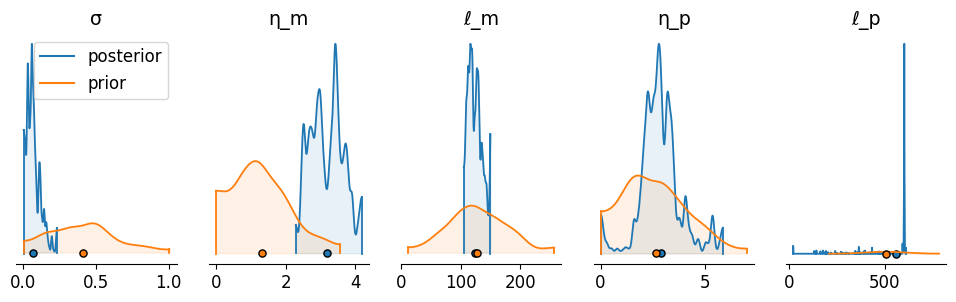

In [ ]:
labels = ['σ','η_m','ℓ_m','η_p','ℓ_p']
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels], 
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 5),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)


## Posterior corner plot

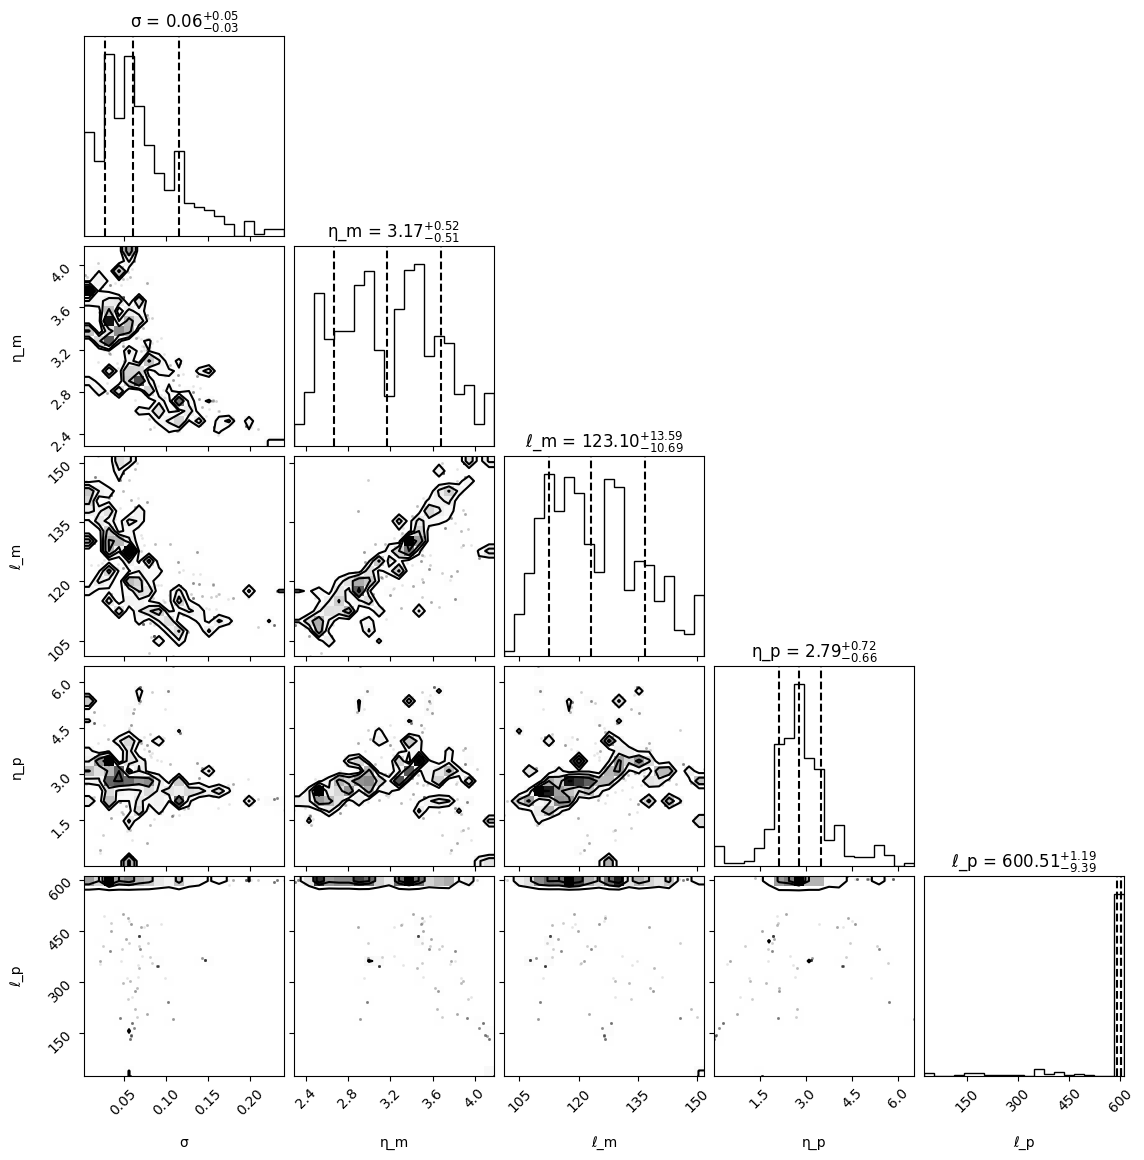

In [ ]:
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

## Condition and make predictions

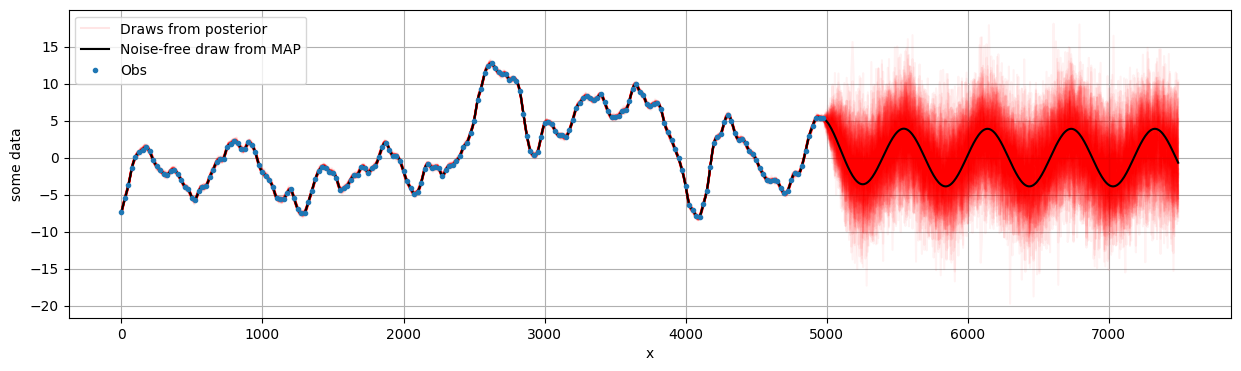

In [ ]:
plt.figure(figsize=(15, 4))
plt.ylabel('some data')
plt.xlabel('x')

xo = np.arange(0,dx*N*1.5,dx/3)[:,None]

for i, draw in enumerate(np.random.uniform(0, samples.shape[0], 100).astype(int)):
    sample = samples[draw, :]
    OI = GPtideVecchia(xd, xo, sample[0], covfunc, sample[1:],
                   order_func=order_func, order_params=order_params)
    out_samp = OI.conditional(yd)
    plt.plot(xo, out_samp, 'r', alpha=0.05, label=None)
    
plt.plot(xo, out_samp, 'r', alpha=0.1, label='Draws from posterior') # Just for legend
    
OI = GPtideVecchia(xd, xo, MAP[0], covfunc, MAP[1:],
                   order_func=order_func, order_params=order_params)
out_map, map_var = OI(yd)

plt.plot(xo, out_map, 'k', label='Noise-free draw from MAP')
plt.plot(xd, yd,'.', label='Obs')
plt.legend()
plt.grid()
